# 03 Análisis Exploratorio de Datos (EDA)

Este cuaderno de Jupyter tiene como objetivo realizar un Análisis Exploratorio de Datos (EDA) básico sobre un conjunto de imágenes aéreas y capas vectoriales relacionadas con la detección de balsas de agua. Utilizaremos herramientas de análisis geoespacial y visualización para entender mejor la distribución y características de las balsas, así como su relación con los marcos de las imágenes aéreas.

Las balsas son estructuras hidráulicas utilizadas en actividades agrícolas y de gestión hídrica, y su correcta identificación y análisis espacial es crucial para entender su impacto en el territorio y para la gestión de los recursos hidrologícos del territorio. 

**Objetivo**: El Análisis Exploratorio de Datos (EDA)  que se presenta aquí tiene como objetivo proporcionar una visión general de los datos vectoriales disponibles, incluyendo las geometrías de las balsas y los marcos de imágenes satelitales asociados. Este análisis nos permitirá: 

* Entender la distribución espacial  de las balsas y su relación con los marcos de imágenes.
* Identificar patrones  en el tamaño, forma y densidad de las balsas.
* Evaluar la calidad de los datos  y detectar posibles problemas antes de proceder a la fase de entrenamiento del modelo YOLOv8.
* Generar insights iniciales  que guiarán el diseño del pipeline de detección y análisis posterior.

**Contenido**:

* Análisis básico de las capas vectoriales de balsas y marcos.
* Cálculo de métricas geométricas (área, perímetro, compacidad) para caracterizar las balsas.
* Visualización espacial de las balsas y su relación con los marcos de imágenes.
* Análisis de densidad espacial y distribución de balsas por marco.
* Muestreo de imágenes satelitales y superposición con las geometrías de las balsas.
* Características de las imagenges aéreas
     


## Importamos librerias necesarias

In [1]:
# Instalar las librerias necesarias
#!pip install contextily

In [2]:
# Importar librerias necesarias
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import show
import contextily as ctx
import os
import pandas as pd
from IPython.display import display

## Características básicas de las capas vectoriales

In [3]:
# Cargamos las capas vectoriales
balsas = gpd.read_file('../data/interim/btn_balsa_en_uso.gpkg')
marcos = gpd.read_file('../data/interim/pnoa_irg_marcos.gpkg')

# Análisis básico de las capas vectoriales
def analisis_basico(gdf, nombre):
    print(f"\nAnálisis de {nombre}:")
    print(f"Número de registros: {len(gdf)}")
    print(f"Columnas: {list(gdf.columns)}")
    print(f"Extensión geográfica:\n{gdf.total_bounds}")
    print(f"CRS: {gdf.crs}")
    print(f"Geometría tipo: {gdf.geom_type.unique()}")
    print("\nMuestra de datos:")
    display(gdf.head(2))

analisis_basico(balsas, "Balsas")
analisis_basico(marcos, "Marcos")


Análisis de Balsas:
Número de registros: 202
Columnas: ['ID', 'area_m2', 'HMTN25', 'geometry']
Extensión geográfica:
[ 247702.47749692 4153695.09580636  276524.55999843 4172416.75630149]
CRS: EPSG:25830
Geometría tipo: ['Polygon']

Muestra de datos:


,ID,area_m2,HMTN25,geometry
0,246804697,3857.247349,0963_3,"POLYGON Z ((249542.02 4153750.663 40, 249526.9..."
1,246797997,5915.347125,0963_3,"POLYGON Z ((250032.364 4154275.495 37, 250014...."



Análisis de Marcos:
Número de registros: 4
Columnas: ['HMTN25', 'RESOLUCION', 'FECHA', 'ESTADO', 'RUTA_TIF', 'geometry']
Extensión geográfica:
[ 247640. 4153248.  277744. 4172720.]
CRS: EPSG:25830
Geometría tipo: ['Polygon']

Muestra de datos:


,HMTN25,RESOLUCION,FECHA,ESTADO,RUTA_TIF,geometry
0,0963_4,0.25,2022-07,Definitivo,../data/raw/raster/PNOA_IRG/PNOA_MA_IRG_OF_ETR...,"POLYGON Z ((262528 4153248 0, 262370 4153248 0..."
1,0963_1,0.25,2022-07,Definitivo,../data/raw/raster/PNOA_IRG/PNOA_MA_IRG_OF_ETR...,"POLYGON Z ((248068 4162928 0, 247920 4162928 0..."


**Balsas**: 
* El conjunto de datos contiene 1115 registros , cada uno representando una balsa con su geometría y atributos.
* Las balsas están georreferenciadas en el sistema de coordenadas EPSG:25830  (ETRS89 / UTM zone 30N), lo que asegura consistencia espacial.
* La extensión geográfica cubre aproximadamente 104 km², lo que sugiere que las balsas están distribuidas en una región específica.
* Todas las geometrías son polígonos.
         
**Marcos**: 
* Hay 42 marcos de imágenes satelitales , cada uno asociado a un código único (HMTN25).
* Los marcos también están en el sistema EPSG:25830 , lo que facilita su integración con las balsas.
* La extensión geográfica de los marcos es ligeramente mayor que la de las balsas, lo que sugiere que las balsas están completamente contenidas dentro de los marcos.

Estos resultados confirman que los datos están bien estructurados y listos para análisis posteriores. 

### Análisis de tamaño y forma

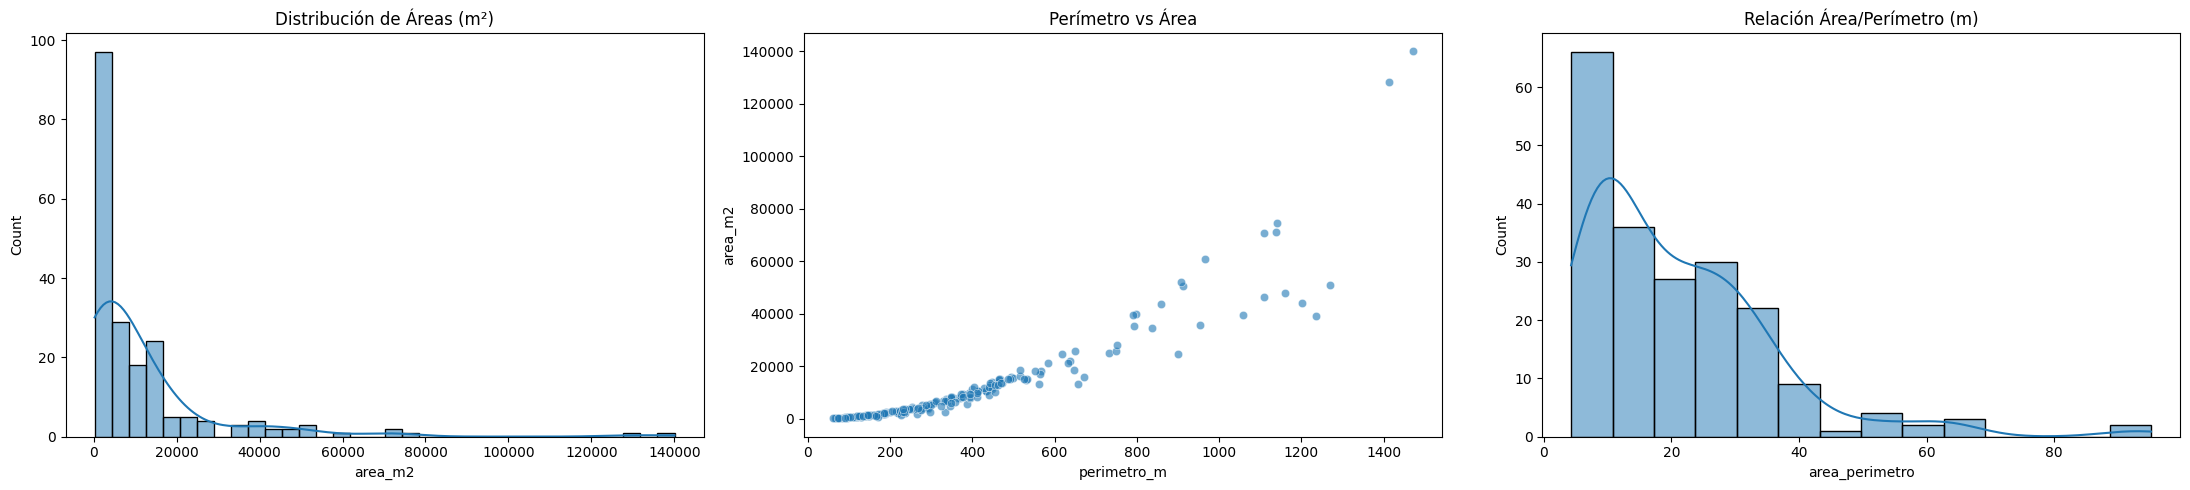

In [4]:
# Calcular métricas
balsas["area_m2"] = balsas.area
balsas["perimetro_m"] = balsas.length
balsas["compacidad"] = (4 * np.pi * balsas.area) / (balsas.length ** 2)
balsas["area_perimetro"] = balsas.area / balsas.length  # Nueva métrica

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(22, 5))

# Área
sns.histplot(balsas["area_m2"], kde=True, ax=axes[0])
axes[0].set_title("Distribución de Áreas (m²)", fontsize=12)

# Perímetro vs Área
sns.scatterplot(x="perimetro_m", y="area_m2", data=balsas, ax=axes[1], alpha=0.6)
axes[1].set_title("Perímetro vs Área", fontsize=12)


# Relación Área/Perímetro
sns.histplot(balsas["area_perimetro"], kde=True, ax=axes[2])
axes[2].set_title("Relación Área/Perímetro (m)", fontsize=12)

plt.tight_layout()
plt.show()

**Distribución de áreas**: 
* La mayoría de las balsas tienen áreas relativamente pequeñas, con una distribución sesgada hacia valores bajos. Esto sugiere que las balsas predominantes son de tamaño reducido, probablemente diseñadas para uso local o agrícola.
* Algunas balsas presentan áreas significativamente mayores, lo que podría indicar estructuras más grandes destinadas a almacenamiento a gran escala.
         
**Relación perímetro-área**: 
* La relación entre el perímetro y el área revela información sobre la compacidad  de las balsas. Las balsas más compactas (cercanas a formas circulares) tienden a ser más eficientes desde el punto de vista hidráulico.
* Se observa una variabilidad significativa en esta relación, lo que sugiere que las balsas tienen formas heterogéneas.
         
**Relación área/perímetro**: 
* Esta métrica complementa el análisis de compacidad. Valores más altos indican formas más compactas y regulares, mientras que valores más bajos sugieren formas irregulares o alargadas.

Estas métricas proporcionan una base sólida para caracterizar las balsas y podrían ser útiles como características adicionales en el modelo YOLOv8. 

## Visualización espacial

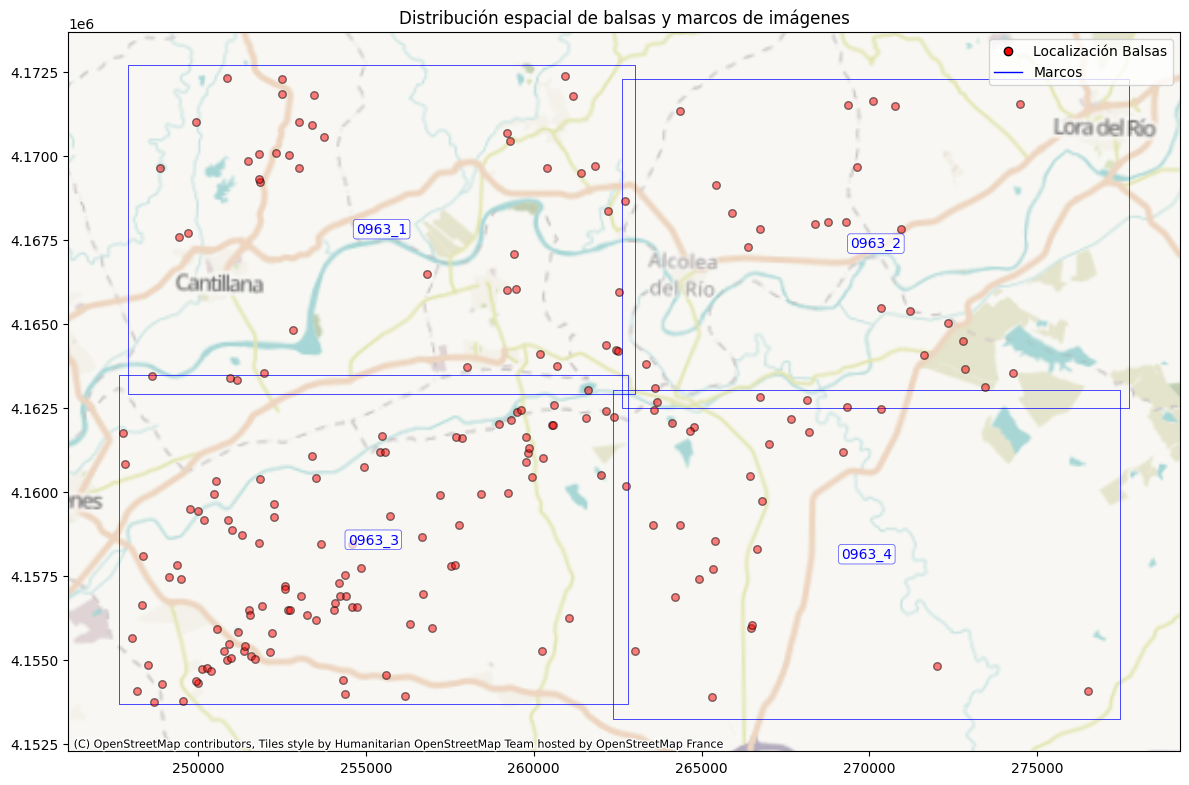

In [5]:
# Definimos tamaño figura
fig, ax = plt.subplots(figsize=(12, 10))

# Plot marcos con etiquetas
marcos.plot(ax=ax, color='none', edgecolor='blue', linewidth=0.5)
# Añadir etiquetas a los marcos
for idx, row in marcos.iterrows():
    ax.annotate(text=row['HMTN25'], 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha='center', va='center',
                fontsize=10, color='blue',
                bbox=dict(boxstyle="round,pad=0.2", 
                         fc="white", ec="blue", lw=0.5, alpha=0.7))

# Plot balsas
balsas_centroids = balsas.geometry.centroid
ax.scatter(balsas_centroids.x, balsas_centroids.y, 
           color='red', edgecolor='black', alpha=0.5, s=30,
           label='Balsas')

# Añadir mapa base
ctx.add_basemap(ax, crs=marcos.crs.to_string(), source=ctx.providers.OpenStreetMap.HOT, alpha=0.8)

# Titulo del mapa
ax.set_title('Distribución espacial de balsas y marcos de imágenes')

# Crear leyenda 
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Localización Balsas',
               markerfacecolor='red', markersize=6, markeredgecolor='black'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Marcos')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

**Distribución espacial**: 
* Las balsas están distribuidas de manera heterogénea dentro de los marcos de imágenes. Algunas áreas presentan una alta concentración de balsas, mientras que otras parecen estar prácticamente vacías.
* La superposición con el mapa base (OpenStreetMap) permite contextualizar las balsas en relación con carreteras, ríos y otros elementos geográficos.

**Correspondencia HMTN25**: 
* La visualización confirma que las balsas están correctamente contenidas dentro de los marcos HMTN25.

## Análisis de correspondencia HMTN25

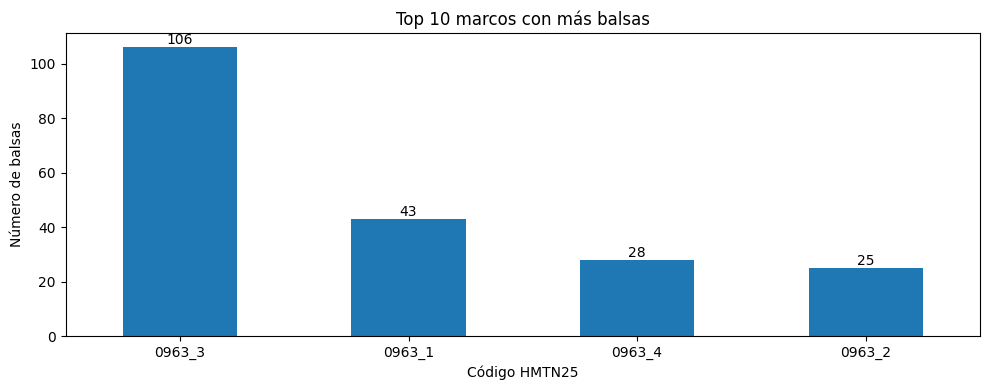

In [6]:
# Verificamos correspondencia entre códigos
codigos_balsas = set(balsas['HMTN25'])
codigos_marcos = set(marcos['HMTN25'])

# Distribución de balsas por marco
distribucion = balsas['HMTN25'].value_counts().head(10)

plt.figure(figsize=(10, 4)) 
ax = distribucion.plot(kind='bar')

plt.title('Top 10 marcos con más balsas')
plt.xlabel('Código HMTN25')
plt.ylabel('Número de balsas')

# Rotar etiquetas del eje x 
ax.set_xticklabels(distribucion.index, rotation=0)

# Añadir etiquetas de valor encima de cada barra
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

**Top 10 marcos con más balsas**:
* Los marcos con mayor número de balsas contienen entre 37 y 100 balsas cada uno, lo que sugiere que estas áreas son regiones clave para el análisis.
* La distribución desigual de balsas entre los marcos puede deberse a factores como la topografía, el uso del suelo o la disponibilidad de agua.

Este análisis ayuda a priorizar los marcos más relevantes para el entrenamiento y validación del modelo YOLOv8.

## Análisis de densidad espacial

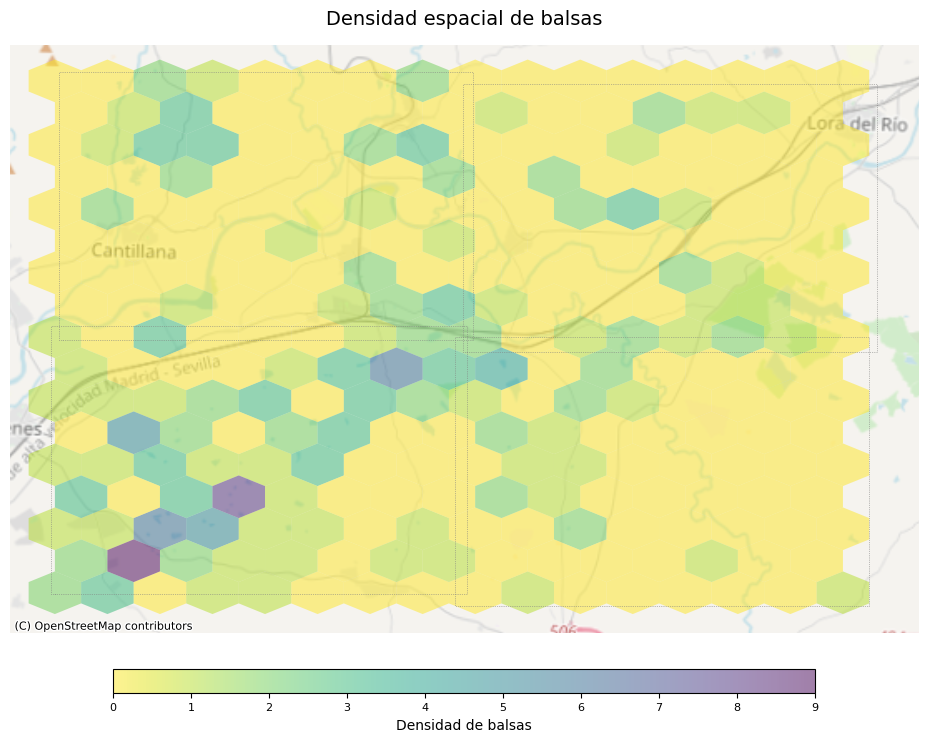

In [7]:
# Definimos tamaño de la figura
fig, ax = plt.subplots(figsize=(12, 8))

# Calcular densidad
x = balsas.geometry.centroid.x
y = balsas.geometry.centroid.y

# Plot de densidad
hexbin = ax.hexbin(x, y, 
                  gridsize=15,
                  cmap='viridis_r',
                  alpha=0.5,
                  edgecolor='none')

# Plot marcos
marcos.boundary.plot(ax=ax, linewidth=0.5, color='gray', linestyle=':')

# Mapa base con proveedor alternativo (3 opciones)
try:
    # Opción 1: OpenStreetMap (siempre disponible)
    ctx.add_basemap(ax, crs=marcos.crs.to_string(), 
                   source=ctx.providers.OpenStreetMap.Mapnik,
                   alpha=0.7)
except:
    # Opción 2: CartoDB (alternativa común)
    ctx.add_basemap(ax, crs=marcos.crs.to_string(),
                   source='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png',
                   alpha=0.7)

# Leyenda compacta horizontal
cbar = plt.colorbar(hexbin, ax=ax, 
                   orientation='horizontal',
                   shrink=0.6,
                   aspect=30,
                   pad=0.05,
                   label='Densidad de balsas')
cbar.ax.tick_params(labelsize=8)

# Ajustes finales
ax.set_title('Densidad espacial de balsas', fontsize=14, pad=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()

**Patrones de densidad**:
* La densidad de balsas varía significativamente en el espacio, con algunas áreas mostrando agrupaciones intensas y otras prácticamente vacías.
* Las zonas con alta densidad coinciden con áreas agrícolas, lo que refuerza la hipótesis de que las balsas están relacionadas con actividades agrícolas.

Este análisis espacial es crucial para entender el contexto de las balsas y optimizar la segmentación de datos para el modelo YOLOv8. 

## Distribución del área de las balsas

Primer cuartil (Q1): 1538.71 m²
Mediana (Q2): 5115.46 m²
Tercer cuartil (Q3): 13640.45 m²


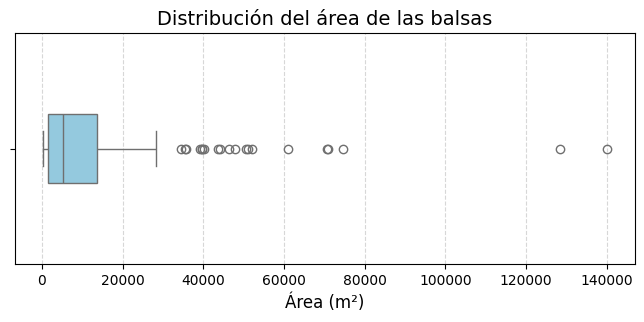

In [8]:
# Calcular los cuartiles
q1 = balsas['area_m2'].quantile(0.25)
q2 = balsas['area_m2'].quantile(0.50)
q3 = balsas['area_m2'].quantile(0.75)

# Crear el texto con los valores de los cuartiles
texto_cuartiles = f"Primer cuartil (Q1): {q1:.2f} m²\nMediana (Q2): {q2:.2f} m²\nTercer cuartil (Q3): {q3:.2f} m²"

print(texto_cuartiles)

# Boxplot de la distribución del área de las balsas
plt.figure(figsize=(8, 3))
sns.boxplot(x=balsas['area_m2'], color='skyblue', width=0.3)
plt.title('Distribución del área de las balsas', fontsize=14)
plt.xlabel('Área (m²)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

**Boxplot del área**:
* La mayoría de las balsas tienen áreas pequeñas, con algunos outliers que representan estructuras mucho más grandes.
* La presencia de outliers. Esta hetereogenidad podría dar problemas para el entrenameinto del modleo YOLOv8 para ser capaz de manejar variabilidad en el tamaño de las balsas.

Este gráfico revela que sería apropiado normalizar o estandarizar las dimensiones de las balsas durante el preprocesamiento de datos. 

## Análisis de cobertura de imágenes

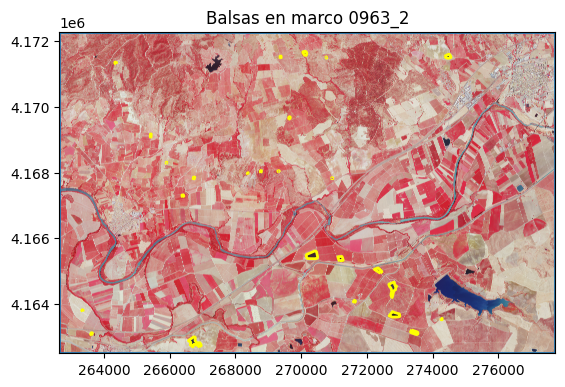

In [9]:
# Muestreo aleatorio de una imagen
marco_muestra = marcos.sample(1)
nombre_imagen = f"../data/interim/pnoa/{marco_muestra['HMTN25'].values[0]}.tif"

# Visualización
fig, ax = plt.subplots()

try:
    with rasterio.open(nombre_imagen) as src:
        # Mostrar la imagen
        show(src, ax=ax)

        # Plot balsas correspondientes
        balsas_muestra = balsas[balsas['HMTN25'] == marco_muestra['HMTN25'].values[0]]
        balsas_muestra.plot(ax=ax, color='none', edgecolor='yellow', linewidth=2)

        # Marco de la imagen
        marco_muestra.boundary.plot(ax=ax, linewidth=2)

        # Título
        ax.set_title(f"Balsas en marco {marco_muestra['HMTN25'].values[0]}")

    # Mostrar la figura
    plt.show()

finally:
    # Liberar memoria
    plt.close(fig)  # Cierra la figura para liberar memoria
    del src  # Elimina la referencia al objeto rasterio.DatasetReader
    del balsas_muestra  # Elimina la referencia a los datos filtrados
    del marco_muestra  # Elimina la referencia al marco seleccionado

**Superposición de balsas e imágenes**:
* La muestra contiene una buena correspondencia entre las balsas y el marco de imagen, lo que valida la precisión de los datos.
* La claridad de las imágenes aéreas de un metro de resolución sugiere que el modelo YOLOv8 tendrá suficiente información visual para realizar detecciones precisas.

Este análisis confirma que las imágenes satelitales son adecuadas para el entrenamiento del modelo. 

## Características de las imagenges aéreas

In [10]:
# Directorio con las imágenges PNOA
directorio = "../data/interim/pnoa"

# Inicializar lista para almacenar metadatos
metadatos = []

# Recorrer archivos en el directorio
for nombre_archivo in os.listdir(directorio):
    if nombre_archivo.lower().endswith((".tif", ".tiff")):
        try:
            ruta_completa = os.path.join(directorio, nombre_archivo)
            
            # Obtener tamaño en MB
            tamano_bytes = os.path.getsize(ruta_completa)
            tamano_mb = tamano_bytes / 1e6  # Convertir bytes a MB
            
            with rasterio.open(ruta_completa) as src:
                # Extraer metadatos clave
                crs_str = str(src.crs).lower() if src.crs else "N/A"  # Convertir CRS a string y normalizar a minúsculas
                
                # Formatear resolución sin decimales
                res_x, res_y = int(src.res[0]), int(src.res[1])  # Convertir a entero
                resolucion = f"{res_x} x {res_y}"
                
                info = {
                    "Archivo": nombre_archivo,
                    "Tamaño (MB)": f"{tamano_mb:.2f} MB",
                    "CRS": str(src.crs),
                    "Resolución (m)": resolucion,  # Usar el nuevo formato
                    "Dimensiones": f"{src.width} x {src.height} px",
                    "Bands": src.count,
                    "Bounds": str(src.bounds),
                    "EPSG": src.crs.to_epsg() if src.crs else "N/A"
                }
                
                # Calcular área solo para CRS proyectados (UTM u otros en metros)
                if src.crs and ("utm" in crs_str or "epsg" in crs_str):  # Verificar si el CRS es proyectado
                    x_res, y_res = src.res
                    area_km2 = (src.width * x_res) * (src.height * y_res) / 1e6
                    info["Área estimada (km²)"] = f"{area_km2:.2f}"
                else:
                    info["Área estimada (km²)"] = "N/A"
                
                metadatos.append(info)
            
        except Exception as e:
            print(f"Error procesando {nombre_archivo}: {str(e)}")

# Crear DataFrame
if metadatos:
    df = pd.DataFrame(metadatos)
    
    # Ordenar por el campo 'Archivo'
    df = df.sort_values(by="Archivo").reset_index(drop=True)
    
    # Mostrar tabla
    display(df)
else:
    print("No se encontraron imágenes GeoTIFF válidas")

,Archivo,Tamaño (MB),CRS,Resolución (m),Dimensiones,Bands,Bounds,EPSG,Área estimada (km²)
0,0963_1.tif,345.76 MB,EPSG:25830,1 x 1,15104 x 9792 px,3,"BoundingBox(left=247920.0, bottom=4162928.0, r...",25830,147.90
1,0963_2.tif,357.44 MB,EPSG:25830,1 x 1,15104 x 9792 px,3,"BoundingBox(left=262640.0, bottom=4162498.0, r...",25830,147.90
2,0963_3.tif,344.88 MB,EPSG:25830,1 x 1,15168 x 9792 px,3,"BoundingBox(left=247640.0, bottom=4153678.0, r...",25830,148.53
3,0963_4.tif,261.51 MB,EPSG:25830,1 x 1,15104 x 9792 px,3,"BoundingBox(left=262370.0, bottom=4153248.0, r...",25830,147.90


**Tamaño de Archivos**  
* Los archivos tienen tamaños que varían entre 215.47 MB  y 392.37 MB .
* La mayoría de los archivos están en el rango de 250-350 MB (las imágenes tienen una resolución y dimensionalidad similares).

**Sistema de Coordenadas (CRS)**  
* Todas las imágenes utilizan el sistema de coordenadas EPSG:25830, Al igual que las capas vectoriales (UTM Zona 30N - ETRS89).

**Resolución Espacial**  
* Todas las imágenes tienen una resolución de 1 x 1 metro, por lo quecada píxel representa un área de 1 m2.
* Esta resolución es adecuada para aplicaciones que requieren un nivel de detalle moderado, como la cartografía o detección de balsas.

**Dimensiones**  
* Las dimensiones varían ligeramente entre 15040 x 9664 px  y 15168 x 9856 px .
* Estos valores indican que las imágenes cubren áreas rectangulares con mayor anchura que altura.

**Número de Bandas**  
* Todas las imágenes tienen 3 bandas (IRG: InfraRojo, Rojo, Verde).

**Área Estimada**  
* El área cubierta por cada imagen varía entre 145.35 km²  y 149.50 km² .
* Estas áreas son consistentes con la resolución y dimensiones de las imágenes, confirmando que las imágenes cubren extensiones relativamente grandes.

**BoundingBox**  
* Los valores de los límites (BoundingBox) muestran que las imágenes están distribuidas en una cuadrícula regular, correspondiente a hojas del MTN25 (Mapa Topográfico Nacional a escala 1:25,000).
     
**Conclusión**  
* *Consistencia* : 
    * Las imágenes son consistentes en términos de CRS, resolución y número de bandas, lo que facilita su procesamiento conjunto.
* *Tamaño y Almacenamiento* : 
    * Los archivos son relativamente grandes.
* *Área Cubierta* : 
    * Cada imagen cubre un área aproximada de 145-150 km², ideal para análisis regionales o estudios locales.
* *Distribución Espacial* : 
    * Las imágenes están organizadas en una cuadrícula sistemática, siguiendo un esquema de teselado predefinido.

## Conclusión  

El EDA realizado proporciona comprensión de los datos vectoriales y su contexto espacial. Los resultados destacan la heterogeneidad en el tamaño, forma y distribución de las balsas, así como su relación con los marcos de imágenes satelitales. Estos insights serán fundamentales para diseñar un pipeline de detección de balsas con YOLOv8, y planteo retos de como el modelo será capa de manejar la variabilidad observada en los datos. 